<a href="https://colab.research.google.com/github/Sumanta1706/Hybrid-movie-recommender/blob/main/Movie_Recommender_(hybrid).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Movie Recommendation model**

**Importing the libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sys
import pickle

In [ ]:
#pwd

In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
#pwd

### Read in the data:

In [ ]:
#Load movies and tags dataset
movies = pd.read_csv('movies.csv')
tags = pd.read_csv('tags.csv')
#Use ratings data to downsample tags data to only movies with ratings 
ratings = pd.read_csv('ratings.csv')
#ratings = ratings.drop_duplicates('movieId')

Printing all the datasets

In [ ]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)


In [ ]:
ratings

,userId,movieId,rating,timestamp
0,1,2.0,3.5,1.112486e+09
1,1,29.0,3.5,1.112485e+09
2,1,32.0,3.5,1.112485e+09
3,1,47.0,3.5,1.112485e+09
4,1,50.0,3.5,1.112485e+09
...,...,...,...,...
15735956,108837,46.0,3.0,9.005183e+08
15735957,108837,52.0,2.0,9.004989e+08
15735958,108837,57.0,2.0,9.005184e+08
15735959,108837,62.0,4.0,9.005176e+08


Due to high number of input features we are limiting the ratings dataset upto 3 million rows

In [ ]:
ratings = ratings.head(3000000)
ratings.shape

(3000000, 4)

In [ ]:
tags

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,1240597180
1,65,208,dark hero,1368150078
2,65,353,dark hero,1368150079
3,65,521,noir thriller,1368149983
4,65,592,dark hero,1368150078
...,...,...,...,...
465559,138446,55999,dragged,1358983772
465560,138446,55999,Jason Bateman,1358983778
465561,138446,55999,quirky,1358983778
465562,138446,55999,sad,1358983772


Seperating all the unique genres

In [ ]:
movies['genres'] = movies['genres'].str.replace('|',' ')
movies.tail()

,movieId,title,genres
27273,131254,Kein Bund für's Leben (2007),Comedy
27274,131256,"Feuer, Eis & Dosenbier (2002)",Comedy
27275,131258,The Pirates (2014),Adventure
27276,131260,Rentun Ruusu (2001),(no genres listed)
27277,131262,Innocence (2014),Adventure Fantasy Horror


### Filtering and cleaning

Limiting our ratings only to the users who have rated more than 55 movies, as it is not feasible to create pivot with such big data frame

In [ ]:
ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 55)

# list the movie titles that survive the filtering
movie_list_rating = ratings_f.movieId.unique().tolist()

We have kept 97% of the original movie titles in ratings data frame

In [ ]:
len(ratings_f.movieId.unique())/len(movies.movieId.unique()) * 100

66.30618080504436

With 57% of the users 

In [ ]:
len(ratings_f.userId.unique())/len(ratings.userId.unique()) * 100

58.141479732388824

Filter the movies data frame

In [ ]:
movies = movies[movies.movieId.isin(movie_list_rating)]

In [ ]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance


Mapping movie to id:

In [ ]:
Mapping_file = dict(zip(movies.title.tolist(), movies.movieId.tolist()))

Dropping the Timestamp column

In [ ]:
tags.drop(['timestamp'],1, inplace=True)
ratings_f.drop(['timestamp'],1, inplace=True)

### Merge the movies and the tags data frame and create a metadata tag for each movie:

In [ ]:
# create a mixed dataframe of movies title, genres and all user tags given to each movie
mixed = pd.merge(movies, tags, on='movieId', how='left')
mixed.head(3)

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1644.0,Watched
1,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,computer animation
2,1,Toy Story (1995),Adventure Animation Children Comedy Fantasy,1741.0,Disney animated feature


Creating metadata from tags and genres

In [ ]:
mixed.fillna("", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(
                                          lambda x: "%s" % ' '.join(x)))
Final = pd.merge(movies, mixed, on='movieId', how='left')
Final ['metadata'] = Final[['tag', 'genres']].apply(
                                          lambda x: ' '.join(x), axis = 1)
Final[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),Watched computer animation Disney animated fea...
1,2,Jumanji (1995),time travel adapted from:book board game child...
2,3,Grumpier Old Men (1995),old people that is actually funny sequel fever...


### Creating a content latent matrix from movie metadata:
#### tf-idf vectors and truncated SVD :

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(Final['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=Final.index.tolist())
print(tfidf_df.shape)

(18087, 22394)


#### The first 200 components explain over 50% of the variance:

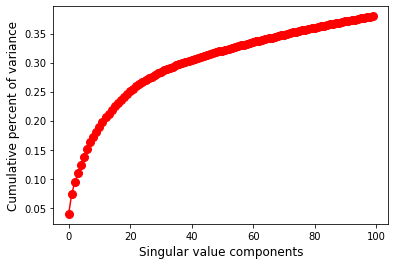

In [ ]:
# Compress with SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
latent_matrix = svd.fit_transform(tfidf_df)
# plot var expalined to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

In [ ]:
#number of latent dimensions to keep
n = 100 
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index=Final.title.tolist())

In [ ]:
# our content latent matrix:
latent_matrix.shape

(18087, 100)

### Creating a collaborative latent matrix from user ratings:

In [ ]:
ratings_f.head()

,userId,movieId,rating
0,1,2.0,3.5
1,1,29.0,3.5
2,1,32.0,3.5
3,1,47.0,3.5
4,1,50.0,3.5


Joining the movies and ratings_f dataset to create the pivot 

In [ ]:
ratings_f1 = pd.merge(movies[['movieId']], ratings_f, on="movieId", how="right")

In [ ]:
ratings_f2 = ratings_f1.pivot(index = 'movieId', columns ='userId', values = 'rating').fillna(0)

In [ ]:
ratings_f2.head(3)

userId,1,2,3,5,7,8,11,13,14,16,18,21,22,23,24,25,26,27,29,31,32,34,35,38,40,41,43,46,48,50,51,53,54,56,58,60,61,65,67,69,...,20265,20267,20268,20269,20270,20272,20273,20274,20278,20282,20283,20285,20287,20288,20289,20291,20292,20293,20294,20296,20297,20298,20300,20301,20304,20307,20308,20309,20310,20311,20313,20315,20317,20320,20321,20322,20325,20326,20327,20328
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,4.0,4.5,4.0,4.5,3.0,0.0,0.0,3.0,4.0,4.0,0.0,0.0,0.0,0.0,3.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,...,4.5,0.0,1.0,5.0,4.0,3.0,0.0,4.0,0.0,0.0,0.0,5.0,5.0,3.0,3.5,0.0,0.0,3.5,4.0,0.0,0.0,0.0,0.0,3.0,4.0,0.0,0.0,3.5,4.0,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,3.5
2,3.5,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.5,3.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.5,3.5,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,4.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0


In [ ]:
len(ratings_f.movieId.unique())

18087

In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=100)
latent_matrix_2 = svd.fit_transform(ratings_f2)
latent_matrix_2_df = pd.DataFrame(
                             latent_matrix_2,
                             index=Final.title.tolist())

Plot variance expalined to see what latent dimensions to use

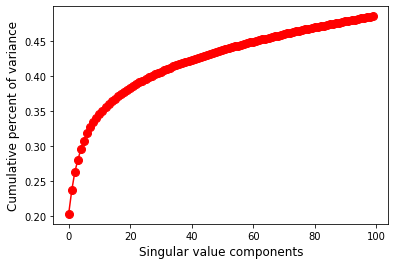

In [ ]:
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '.-', ms = 16, color='red')
plt.xlabel('Singular value components', fontsize= 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)        
plt.show()

### Running a content / collaborative and hybrid cosine Similarity: 

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# take the latent vectors for a selected movie from both content 
# and collaborative matrixes
a_1 = np.array(latent_matrix_1_df.loc['Toy Story (1995)']).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc['Toy Story (1995)']).reshape(1, -1)

# calculate the similartity of this movie with the others in the list
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

# an average measure of both content and collaborative 
hybrid = ((score_1 + score_2)/2.0)

# form a data frame of similar movies 
dictDf = {'content': score_1 , 'collaborative': score_2, 'hybrid': hybrid} 
similar = pd.DataFrame(dictDf, index = latent_matrix_1_df.index )

#sort it on the basis of either: content, collaborative or hybrid, 
# here : content
similar.sort_values('content', ascending=False, inplace=True)

similar[1:].head(11)

,content,collaborative,hybrid
Toy Story 2 (1999),0.964102,0.804576,0.884339
Ice Age (2002),0.926801,0.530227,0.728514
Ratatouille (2007),0.926494,0.471445,0.698969
Finding Nemo (2003),0.905495,0.651444,0.778470
"Bug's Life, A (1998)",0.904251,0.751768,0.828009
"Monsters, Inc. (2001)",0.886385,0.686198,0.786291
Up (2009),0.867629,0.419977,0.643803
Toy Story 3 (2010),0.864931,0.439240,0.652086
Monsters University (2013),0.850212,0.197306,0.523759
Planes: Fire & Rescue (2014),0.846115,0.102038,0.474077


### Use matrix factorization model:

Using the 'surprise' library package

In [ ]:
pip install surprise

In [ ]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

Instantiate a reader and read in our rating data

In [ ]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_f[['userId','movieId','rating']], reader)

# train SVD on 75% of known rates
trainset, testset = train_test_split(data, test_size=.25)
algorithm = SVD()
algorithm.fit(trainset)
predictions = algorithm.test(testset)

# check the accuracy using Root Mean Square Error
accuracy.rmse(predictions)

RMSE: 0.8032


0.8031938545682693

Defining the prediction model based on user ratings

In [ ]:
def pred_user_rating(ui):
    if ui in ratings_f.userId.unique():
        ui_list = ratings_f[ratings_f.userId == ui].movieId.tolist()
        d = {k: v for k,v in Mapping_file.items() if not v in ui_list}        
        predictedL = []
        for i, j in d.items():     
            predicted = algorithm.predict(ui, j)
            predictedL.append((i, predicted[3])) 
        pdf = pd.DataFrame(predictedL, columns = ['movies', 'ratings'])
        pdf.sort_values('ratings', ascending=False, inplace=True)  
        pdf.set_index('movies', inplace=True)    
        return pdf.head(10)        
    else:
        print("User Id does not exist in the list!")
        return None

Getting results

In [ ]:
user_id = 1
pred_user_rating(user_id)

,ratings
movies,
Fawlty Towers (1975-1979),4.623318
Avatar (2009),4.583803
Elmer Gantry (1960),4.565436
Cosmos (1980),4.555046
"Sorrow and the Pity, The (Le chagrin et la pitié) (1969)",4.552844
Waco: The Rules of Engagement (1997),4.542631
"Celebration, The (Festen) (1998)",4.528030
Black Mirror (2011),4.518950
Louis C.K.: Chewed Up (2008),4.492094
